# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [0]:
from sklearn.cluster import AgglomerativeClustering

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 5000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (5000, 10)


Id   ProductId          UserId                      ProfileName  \
0   1  B001E4KFG0  A3SGXH7AUHU8GW                       delmartian   
1   2  B00813GRG4  A1D87F6ZCVE5NK                           dll pa   
2   3  B000LQOCH0   ABXLMWJIXXAIN  Natalia Corres "Natalia Corres"   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     1                       1      1  1303862400   
1                     0                       0      0  1346976000   
2                     1                       1      1  1219017600   

                 Summary                                               Text  
0  Good Quality Dog Food  I have bought several of the Vitality canned d...  
1      Not as Advertised  Product arrived labeled as Jumbo Salted Peanut...  
2  "Delight" says it all  This is a confection that has been around a fe...

In [0]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [0]:
print(display.shape)
display.head()

(80668, 7)


UserId   ProductId             ProfileName        Time  Score  \
0  #oc-R115TNMSPFT9I7  B007Y59HVM                 Breyton  1331510400      2   
1  #oc-R11D9D7SHXIJB9  B005HG9ET0  Louis E. Emory "hoppy"  1342396800      5   
2  #oc-R11DNU2NBKQ23Z  B007Y59HVM        Kim Cieszykowski  1348531200      1   
3  #oc-R11O5J5ZVQE25C  B005HG9ET0           Penguin Chick  1346889600      5   
4  #oc-R12KPBODL2B5ZD  B007OSBE1U   Christopher P. Presta  1348617600      1   

                                                Text  COUNT(*)  
0  Overall its just OK when considering the price...         2  
1  My wife has recurring extreme muscle spasms, u...         3  
2  This coffee is horrible and unfortunately not ...         2  
3  This will be the bottle that you grab from the...         3  
4  I didnt like this coffee. Instead of telling y...         2

In [0]:
display[display['UserId']=='AZY10LLTJ71NX']

UserId   ProductId                      ProfileName        Time  \
80638  AZY10LLTJ71NX  B006P7E5ZI  undertheshrine "undertheshrine"  1334707200   

       Score                                               Text  COUNT(*)  
80638      5  I was recommended to try green tea extract to ...         5

In [0]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

Id   ProductId         UserId      ProfileName  HelpfulnessNumerator  \
0   78445  B000HDL1RQ  AR5J8UI46CURR  Geetha Krishnan                     2   
1  138317  B000HDOPYC  AR5J8UI46CURR  Geetha Krishnan                     2   
2  138277  B000HDOPYM  AR5J8UI46CURR  Geetha Krishnan                     2   
3   73791  B000HDOPZG  AR5J8UI46CURR  Geetha Krishnan                     2   
4  155049  B000PAQ75C  AR5J8UI46CURR  Geetha Krishnan                     2   

   HelpfulnessDenominator  Score        Time  \
0                       2      5  1199577600   
1                       2      5  1199577600   
2                       2      5  1199577600   
3                       2      5  1199577600   
4                       2      5  1199577600   

                             Summary  \
0  LOACKER QUADRATINI VANILLA WAFERS   
1  LOACKER QUADRATINI VANILLA WAFERS   
2  LOACKER QUADRATINI VANILLA WAFERS   
3  LOACKER QUADRATINI VANILLA WAFERS   
4  LOACKER QUADRATINI VANILLA WAFERS   

                                                Text  
0  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
1  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
2  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
3  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...  
4  DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...

As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [0]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [5]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(4986, 10)

In [6]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

99.72

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [0]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

Id   ProductId          UserId              ProfileName  \
0  64422  B000MIDROQ  A161DK06JJMCYF  J. E. Stephens "Jeanne"   
1  44737  B001EQ55RW  A2V0I904FH7ABY                      Ram   

   HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
0                     3                       1      5  1224892800   
1                     3                       2      4  1212883200   

                                        Summary  \
0             Bought This for My Son at College   
1  Pure cocoa taste with crunchy almonds inside   

                                                Text  
0  My son loves spaghetti so I didn't hesitate or...  
1  It was almost a 'love at first bite' - the per...

In [0]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [8]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(4986, 10)


1    4178
0     808
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [0]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
I recently tried this flavor/brand and was surprised at how delicious these chips are.  The best thing was that there were a lot of "brown" chips in the bsg (my favorite), so I bought some more through amazon and shared with family and friends.  I am a little disappointed that there are not, so far, very many brown chips in these bags, but the flavor is still very good.  I like them better than the yogurt and green onion flavor because they do not seem to be as salty, and the onion flavor is better.  If you haven't eaten Kettle chips before, I recommend that you try a bag before buying bulk.  They are thicker and crunchier than Lays but just as fresh out of the bag.
Wow.  So far, two two-star reviews.  One obviously had no 

In [0]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

# soup = BeautifulSoup(sent_0, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1000, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_1500, 'lxml')
# text = soup.get_text()
# print(text)
# print("="*50)

# soup = BeautifulSoup(sent_4900, 'lxml')
# text = soup.get_text()
# print(text)

In [0]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [0]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Wow.  So far, two two-star reviews.  One obviously had no idea what they were ordering; the other wants crispy cookies.  Hey, I am sorry; but these reviews do nobody any good beyond reminding us to look  before ordering.<br /><br />These are chocolate-oatmeal cookies.  If you do not like that combination, do not order this type of cookie.  I find the combo quite nice, really.  The oatmeal sort of "calms" the rich chocolate flavor and gives the cookie sort of a coconut-type consistency.  Now let is also remember that tastes differ; so, I have given my opinion.<br /><br />Then, these are soft, chewy cookies -- as advertised.  They are not "crispy" cookies, or the blurb would say "crispy," rather than "chewy."  I happen to like raw cookie dough; however, I do not see where these taste like raw cookie dough.  Both are soft, however, so is this the confusion?  And, yes, they stick together.  Soft cookies tend to do that.  They are not individually wrapped, which would add to the cost.  Oh y

In [0]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

Why is this $[...] when the same product is available for $[...] here?<br /> /><br />The Victor  and  traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


In [0]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Wow So far two two star reviews One obviously had no idea what they were ordering the other wants crispy cookies Hey I am sorry but these reviews do nobody any good beyond reminding us to look before ordering br br These are chocolate oatmeal cookies If you do not like that combination do not order this type of cookie I find the combo quite nice really The oatmeal sort of calms the rich chocolate flavor and gives the cookie sort of a coconut type consistency Now let is also remember that tastes differ so I have given my opinion br br Then these are soft chewy cookies as advertised They are not crispy cookies or the blurb would say crispy rather than chewy I happen to like raw cookie dough however I do not see where these taste like raw cookie dough Both are soft however so is this the confusion And yes they stick together Soft cookies tend to do that They are not individually wrapped which would add to the cost Oh yeah chocolate chip cookies tend to be somewhat sweet br br So if you wa

In [0]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [12]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 4986/4986 [00:02<00:00, 2142.46it/s]


In [0]:
preprocessed_reviews[1500]

'wow far two two star reviews one obviously no idea ordering wants crispy cookies hey sorry reviews nobody good beyond reminding us look ordering chocolate oatmeal cookies not like combination not order type cookie find combo quite nice really oatmeal sort calms rich chocolate flavor gives cookie sort coconut type consistency let also remember tastes differ given opinion soft chewy cookies advertised not crispy cookies blurb would say crispy rather chewy happen like raw cookie dough however not see taste like raw cookie dough soft however confusion yes stick together soft cookies tend not individually wrapped would add cost oh yeah chocolate chip cookies tend somewhat sweet want something hard crisp suggest nabiso ginger snaps want cookie soft chewy tastes like combination chocolate oatmeal give try place second order'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [0]:
## Similartly you can do preprocessing for review summary also.

# [4] Featurization

## [4.1] BAG OF WORDS

In [13]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [14]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [65]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=200, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('excellent', 0.9980805516242981), ('snack', 0.9978074431419373), ('alternative', 0.9976629614830017), ('especially', 0.9975399374961853), ('amazing', 0.9975348114967346), ('looking', 0.9974856376647949), ('enjoy', 0.9974850416183472), ('satisfying', 0.9974431991577148), ('licorice', 0.9973960518836975), ('ok', 0.9973787069320679)]
[('experience', 0.9998412728309631), ('varieties', 0.999840259552002), ('stand', 0.9998338222503662), ('remember', 0.9998307824134827), ('easily', 0.9998269081115723), ('simply', 0.999824583530426), ('note', 0.9998239278793335), ('peanuts', 0.9998235702514648), ('hit', 0.9998217225074768), ('tomatoes', 0.9998214840888977)]


In [66]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [67]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(200) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|██████████| 4986/4986 [00:06<00:00, 746.87it/s]

4986
200


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [69]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(200) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|██████████| 4986/4986 [00:38<00:00, 131.09it/s]


# [5] Assignment 10: K-Means, Agglomerative & DBSCAN Clustering

<ol>
    <li><strong>Apply K-means Clustering on these feature sets:</strong>
        <ul>
    <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘k’ using the elbow-knee method (plot k vs inertia_)</li>
    <li>Once after you find the k clusters, plot the word cloud per each cluster so that at a single
go we can analyze the words in a cluster.</li>          
        </ul>
    </li>
    <br>
    <li><strong>Apply Agglomerative Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Apply agglomerative algorithm and try a different number of clusters like 2,5 etc.</li>
    <li>Same as that of K-means, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews or so(as this is very computationally expensive one)</li>
        </ul>
    </li>
    <br>
    <br>
    <li><strong>Apply DBSCAN Clustering on these feature sets:</strong>
        <ul>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
    <li>Find the best ‘Eps’ using the <a href='https://stackoverflow.com/questions/12893492/choosing-eps-and-minpts-for-dbscan-r/48558030#48558030'>elbow-knee method.</a></li>
    <li>Same as before, plot word clouds for each cluster and summarize in your own words what that cluster is representing.</li>
            <li>You can take around 5000 reviews for this as well.</li>
        </ul>
    </li>
</ol>

## [5.1] K-Means Clustering

### [5.1.1] Applying K-Means Clustering on BOW,<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.2] Wordclouds of clusters obtained after applying k-means on BOW<font color='red'> SET 1</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.3] Applying K-Means Clustering on TFIDF,<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.4] Wordclouds of clusters obtained after applying k-means on TFIDF<font color='red'> SET 2</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.5] Applying K-Means Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.6] Wordclouds of clusters obtained after applying k-means on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.7] Applying K-Means Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

### [5.1.8] Wordclouds of clusters obtained after applying k-means on TFIDF W2V<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

## [5.2] Agglomerative Clustering

### [5.2.1] Applying Agglomerative Clustering on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation
sent_vectors = np.array(sent_vectors)

In [0]:
# Taking n_clusters = 2
agg_clustering_model = AgglomerativeClustering(n_clusters = 2 , affinity = 'euclidean' , linkage = 'complete').fit(sent_vectors)


In [0]:
reviews = final['Text'].values
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range (agg_clustering_model.labels_.shape[0]):
    if agg_clustering_model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])
 

In [0]:
# Defining Helper Function for representing clusters with the help of Wordcloud
from wordcloud import WordCloud, STOPWORDS
stopwords = set(STOPWORDS)

def cluster_wordcloud(text):
    wordcloud = WordCloud(max_font_size=50, max_words=100,stopwords=stopwords ,background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

### [5.2.2] Wordclouds of clusters obtained after applying Agglomerative Clustering on AVG W2V<font color='red'> SET 3</font>

Amazon Review - 1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


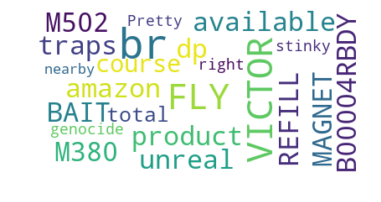

Amazon Review - 2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


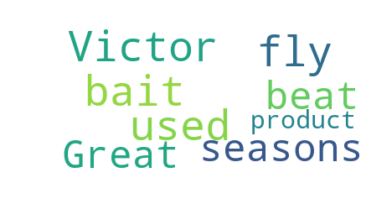

Amazon Review - 3
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
****************************************************************************************************


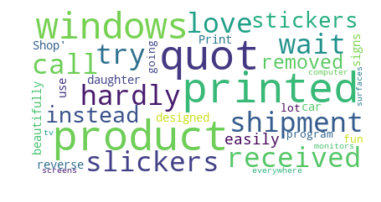

In [74]:
# Please write all the code with proper documentation

# For Cluster -1

counter = 1;
for i in range(len(cluster1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster1[i])
        print("*"*100)
        cluster_wordcloud(cluster1[i])
    counter +=1


Amazon Review - 1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...
****************************************************************************************************


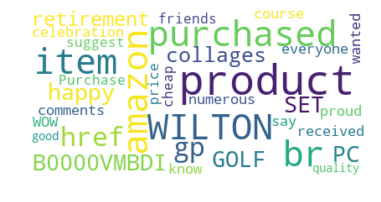

Amazon Review - 2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!
****************************************************************************************************


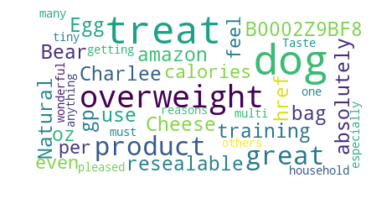

Amazon Review - 3
<a href="http://www.amazon.com/gp/product/B000EH2AMA">Mrs. May's Dry-Roasted Snack, Pumpkin Crunch, 2-Ounce Pouches (Pack of 24)</a><br />Pumpkin Crunch is great.<br />Stick with 2oz. size (2 servings)<br />Much too easy to consume entire 5.5oz. bag without realizing it.<br />:-D LOL
****************************************************************************************************


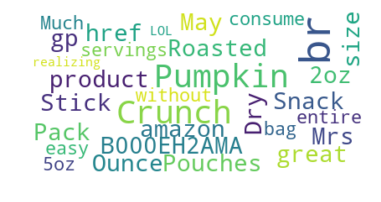

In [75]:
# Cluster -2

counter = 1;
for i in range(len(cluster2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster2[i])
        print("*"*100)
        cluster_wordcloud(cluster2[i])
    counter +=1

In [0]:
# Taking n_clusters = 5
agg_clustering_model = AgglomerativeClustering(n_clusters = 5 , affinity = 'euclidean' , linkage = 'complete').fit(sent_vectors)


In [0]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(agg_clustering_model.labels_.shape[0]):
    if agg_clustering_model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif agg_clustering_model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif agg_clustering_model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif agg_clustering_model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 

Amazon Review - 1
I bought this same brand from an online Indian grocery store that usually has excellent products.  I was able to turn it into cream/butter, using my super blender and adding some water, but it barely had any flavor.  I usually buy the Chao Kah brand of coconut cream (which is quite tasty and flavorful) and read another review for a different product for making your own coconut cream.  My complaint is not the shreds or texture.  Mine was just virtually tasteless.
****************************************************************************************************


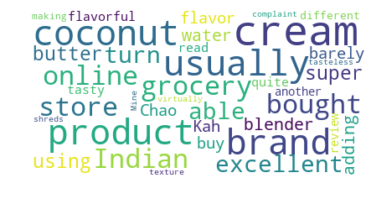

Amazon Review - 2
This company is an American Classic been in business over 90 years. Why? Because it is the best hot sauce and taco sauce bar none. There are some other good brands oout there, but this is the best and nothing compares to it. The Hot sauce has reasonable heat and bite and adds unique flavor to your favorite Mex foods. The taco (Mild) sauce is milder and just perfect on tacos, enchaladas, tostadas, tamales, Bell Beefers, and frozen mex dinners. The harder to find green sauce is to die for. Great on everything! Unfortunately I don't see the green stuff on Amazon but you can find it. Just get it. Try all three. I grew up with this stuff so am very partial to it. I keep about five or six bottles (each variety) on my shelves at all times. After you try this you will not want to go back to the run of the mill commercial stuff.<a href="http://www.amazon.com/gp/product/B0000GGHZQ">Pico Pica Mexican Hot Sauce 7 oz - HOT</a><a href="http://www.amazon.com/gp/product/B0000GGI00">P

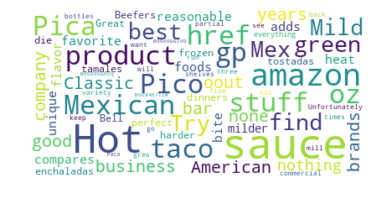

Amazon Review - 3
I love Pico Pica.  It adds some flavor, and it's not too hot. I eat it at least 2 meals every day. It's good on eggs, it's good on pizza, it's good on vegetables.<br /><br />Really, you can't go wrong.
****************************************************************************************************


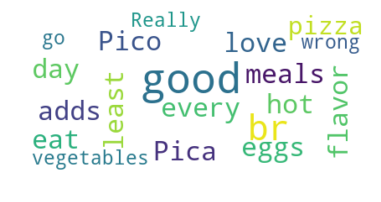

In [78]:
# For Cluster -1

counter = 1;
for i in range(len(cluster1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster1[i])
        print("*"*100)
        cluster_wordcloud(cluster1[i])
    counter +=1


Amazon Review - 1
Good beans.  I can't find these in the grocery stores where I live, but ordered them through this retailer with no problems.
****************************************************************************************************


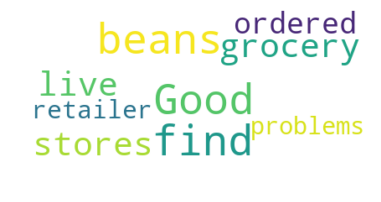

Amazon Review - 2
The best sauce on the market.  We use it on almost any food product but it is especially good on veggies.
****************************************************************************************************


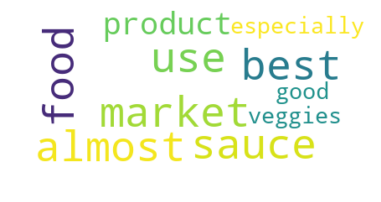

Amazon Review - 3
This is the best way to cook a roast.  Our local grocery went out of buisness and so I could not find this product till I looked here.  Please continue to keep this product available!
****************************************************************************************************


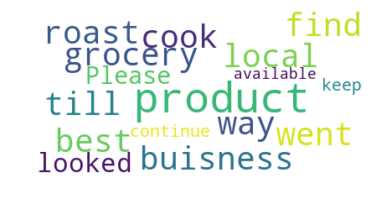

In [79]:
# For Cluster -2


counter = 1;
for i in range(len(cluster2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster2[i])
        print("*"*100)
        cluster_wordcloud(cluster2[i])
    counter +=1


Amazon Review - 1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


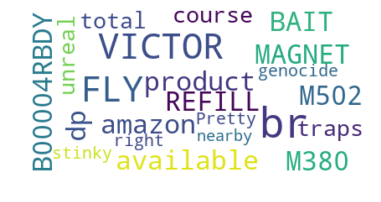

Amazon Review - 2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


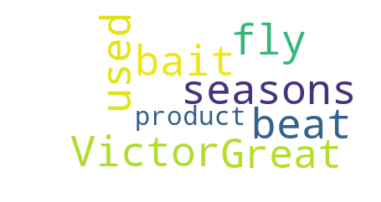

Amazon Review - 3
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
****************************************************************************************************


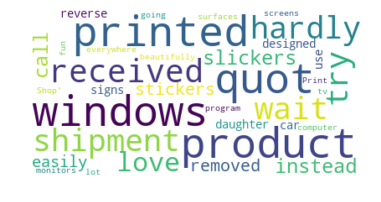

In [80]:
# For Cluster -3

counter = 1;
for i in range(len(cluster3)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster3[i])
        print("*"*100)
        cluster_wordcloud(cluster3[i])
    counter +=1


Amazon Review - 1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...
****************************************************************************************************


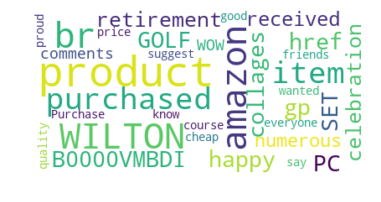

Amazon Review - 2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!
****************************************************************************************************


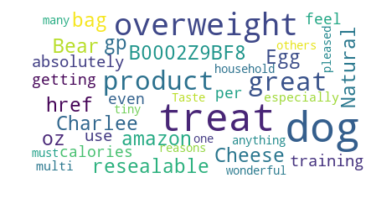

Amazon Review - 3
<a href="http://www.amazon.com/gp/product/B000EH2AMA">Mrs. May's Dry-Roasted Snack, Pumpkin Crunch, 2-Ounce Pouches (Pack of 24)</a><br />Pumpkin Crunch is great.<br />Stick with 2oz. size (2 servings)<br />Much too easy to consume entire 5.5oz. bag without realizing it.<br />:-D LOL
****************************************************************************************************


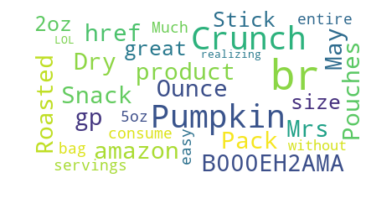

In [81]:
# For Cluster -4

counter = 1;
for i in range(len(cluster4)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster4[i])
        print("*"*100)
        cluster_wordcloud(cluster4[i])
    counter +=1


Amazon Review - 1
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
****************************************************************************************************


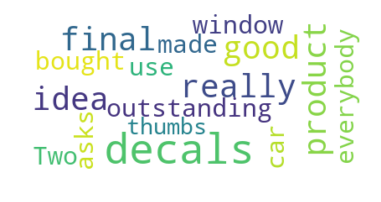

Amazon Review - 2
Mae Ploy Sweet Chili Sauce is becoming a standard condiment on my dinner table. It has just the right blend of sweet and heat; Mae Ploy enhances the taste of all meat and fish foods. Catsup is almost a condiment of the past. Salsa and Mae Ploy are the answers!
****************************************************************************************************


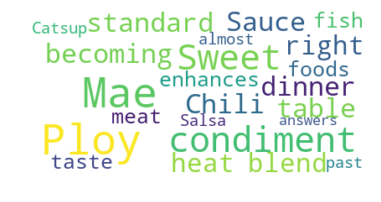

Amazon Review - 3
I purchased this item to celebrate the birth of my grandson.  I should have opted for real cigars, they might have tasted better. These cigars were very hard and hurt my teeth to chew. Not to mention that these gum cigars were much too sweet.
****************************************************************************************************


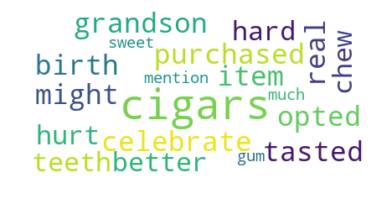

In [82]:
# For Cluster -5

counter = 1;
for i in range(len(cluster5)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster5[i])
        print("*"*100)
        cluster_wordcloud(cluster5[i])
    counter +=1


### [5.2.3] Applying Agglomerative Clustering on TFIDF W2V,<font color='red'> SET 4</font>

In [0]:
# Please write all the code with proper documentation

tfidf_sent_vectors = np.array(tfidf_sent_vectors)

In [0]:
# Taking n_clusters = 2

agg_clustering_model = AgglomerativeClustering(n_clusters = 2 , affinity = 'euclidean' , linkage = 'complete').fit(tfidf_sent_vectors)

In [0]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []

for i in range (agg_clustering_model.labels_.shape[0]):
    if agg_clustering_model.labels_[i] == 0:
        cluster1.append(reviews[i])
    else :
        cluster2.append(reviews[i])

### [5.2.4] Wordclouds of clusters obtained after applying Agglomerative Clustering on TFIDF W2V<font color='red'> SET 4</font>

Amazon Review - 1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


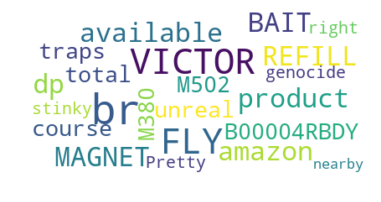

Amazon Review - 2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


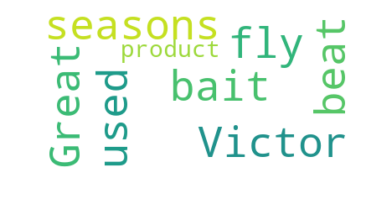

Amazon Review - 3
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
****************************************************************************************************


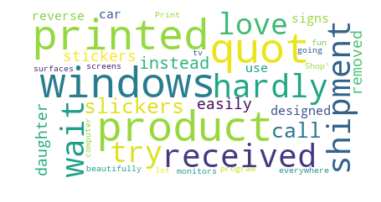

In [86]:
# Please write all the code with proper documentation
# For Cluster -1

counter = 1;
for i in range(len(cluster1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster1[i])
        print("*"*100)
        cluster_wordcloud(cluster1[i])
    counter +=1

Amazon Review - 1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...
****************************************************************************************************


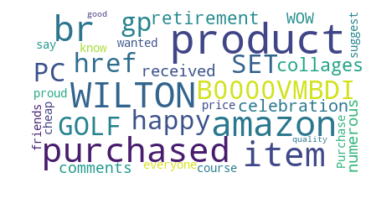

Amazon Review - 2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!
****************************************************************************************************


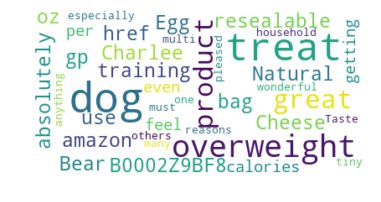

Amazon Review - 3
<a href="http://www.amazon.com/gp/product/B000EH2AMA">Mrs. May's Dry-Roasted Snack, Pumpkin Crunch, 2-Ounce Pouches (Pack of 24)</a><br />Pumpkin Crunch is great.<br />Stick with 2oz. size (2 servings)<br />Much too easy to consume entire 5.5oz. bag without realizing it.<br />:-D LOL
****************************************************************************************************


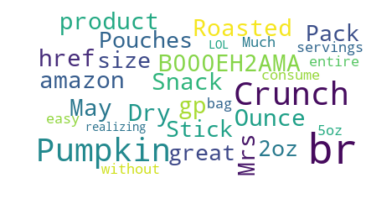

In [87]:
# For Cluster -2

counter = 1;
for i in range(len(cluster2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster2[i])
        print("*"*100)
        cluster_wordcloud(cluster2[i])
    counter +=1

In [0]:
# Taking n_clusters = 5
agg_clustering_model = AgglomerativeClustering(n_clusters = 5 , affinity = 'euclidean' , linkage = 'complete').fit(tfidf_sent_vectors)


In [0]:
# Getting all the reviews in different clusters
cluster1 = []
cluster2 = []
cluster3 = []
cluster4 = []
cluster5 = []

for i in range(agg_clustering_model.labels_.shape[0]):
    if agg_clustering_model.labels_[i] == 0:
        cluster1.append(reviews[i])
    elif agg_clustering_model.labels_[i] == 1:
        cluster2.append(reviews[i])
    elif agg_clustering_model.labels_[i] == 2:
        cluster3.append(reviews[i])
    elif agg_clustering_model.labels_[i] == 3:
        cluster4.append(reviews[i])
    else :
        cluster5.append(reviews[i]) 

Amazon Review - 1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.
****************************************************************************************************


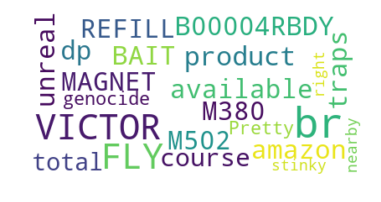

Amazon Review - 2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!
****************************************************************************************************


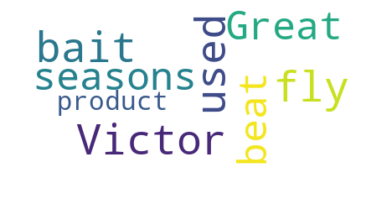

Amazon Review - 3
We have been using this food for about 6 months now and find it to be just excellent! Other than the fact our two dogs (a Coton de Tulear 15lbs, and Standard Poodle puppy 40lbs) both love the food, but are thriving.  Their coats are in excellent condition and their overall structure is perfect.  Good tasting to the dog and good for them and a good deal for the owner.  All around the best food we have ever used.  Excellent!!!
****************************************************************************************************


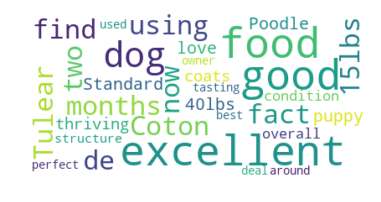

In [90]:
# For Cluster - 1

counter = 1;
for i in range(len(cluster1)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster1[i])
        print("*"*100)
        cluster_wordcloud(cluster1[i])
    counter +=1

Amazon Review - 1
I just received my shipment and could hardly wait to try this product. We love &quot;slickers&quot; which is what we call them, instead of stickers because they can be removed so easily. My daughter designed signs to be  printed in reverse to use on her car windows. They printed beautifully (we  have 'The Print Shop' program). I am going to have a lot of fun with this  product because there are windows everywhere and other surfaces like tv  screens and computer monitors.
****************************************************************************************************


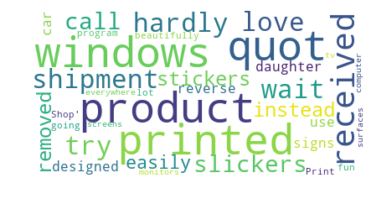

Amazon Review - 2
This was a really good idea and the final product is outstanding. I use the decals on my car window and everybody asks where i bought the decals i made.  Two thumbs up!
****************************************************************************************************


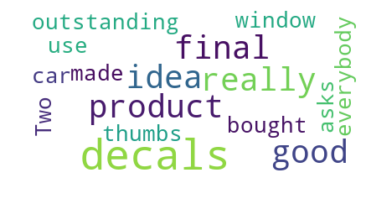

Amazon Review - 3
I'm glad my 45lb cocker/standard poodle puppy loves the stuff because I trust the brand and its superior nutrition. Compare labels! My previous feed (Pedigree) was mostly corn. My little dude is healthy and happy and high energy and has a glossy coat. Also, superior nutrition produces smaller, compact stools.
****************************************************************************************************


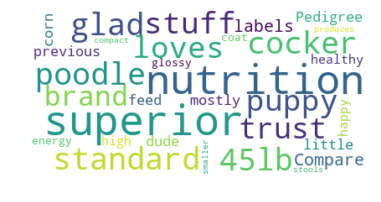

In [91]:
# For Cluster -2
counter = 1;
for i in range(len(cluster2)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster2[i])
        print("*"*100)
        cluster_wordcloud(cluster2[i])
    counter +=1

Amazon Review - 1
I love this water.  It is very uplifting.  I feel better drinking it.  It is arsenic free, flouride free, chromium 6 free, chlorine free,and mtbe free-something about reverse osmosis and medicinal grade oxygen really works.  At work, we are no longer allowed to drink soda in our classrooms, so I bought some Penta water. I am hooked.  I like the one liter size bottles.  I wish you would sell those also!  I was lucky to purchase this at Dorthy Lane Market!  Buy this water!
****************************************************************************************************


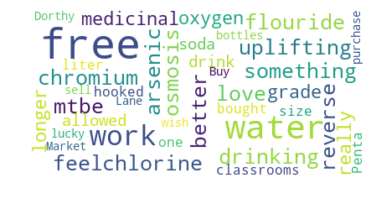

Amazon Review - 2
My 1 year old loves these! Great snack! I've tried to find these at my stores and can't seem to get them very often. Love that they are organic and my one year old loves that Elmo is on the box!
****************************************************************************************************


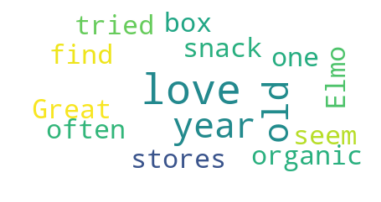

Amazon Review - 3
son is gluten free, but not fun and tasty free, so these are great!!! I put<br />his icecream on these for a COOL snack.  Taste good to him too just plain.
****************************************************************************************************


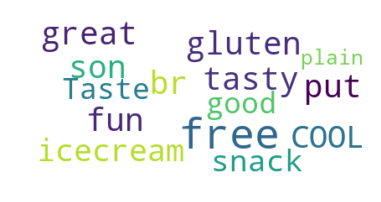

In [92]:
# For Cluser-3
counter = 1;
for i in range(len(cluster3)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster3[i])
        print("*"*100)
        cluster_wordcloud(cluster3[i])
    counter +=1

Amazon Review - 1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...
****************************************************************************************************


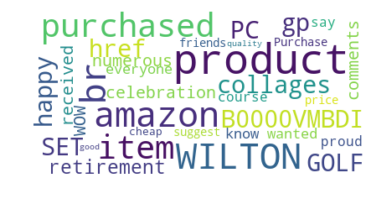

Amazon Review - 2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!
****************************************************************************************************


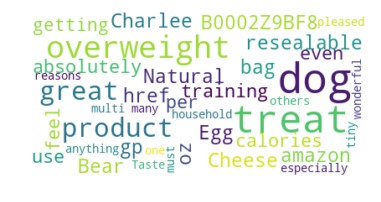

Amazon Review - 3
<a href="http://www.amazon.com/gp/product/B000EH2AMA">Mrs. May's Dry-Roasted Snack, Pumpkin Crunch, 2-Ounce Pouches (Pack of 24)</a><br />Pumpkin Crunch is great.<br />Stick with 2oz. size (2 servings)<br />Much too easy to consume entire 5.5oz. bag without realizing it.<br />:-D LOL
****************************************************************************************************


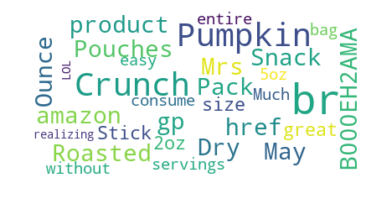

In [93]:
# For Cluster-4
counter = 1;
for i in range(len(cluster4)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster4[i])
        print("*"*100)
        cluster_wordcloud(cluster4[i])
    counter +=1

Amazon Review - 1
This is the best Sweet Chili sauce I have found anywhere. Some say its to sweet but hey, it's a Sweet Chili sauce and its supposed to be sweet. It has a rich full flavor that everyone in my family likes. Even my wife who can't stand anything anyone would consider hot just loves this sauce. I'm a pepper head myself. If you're like me and like a little more kick try adding some Sriracha Hot Chili Sauce to this and you will learn to love it too.
****************************************************************************************************


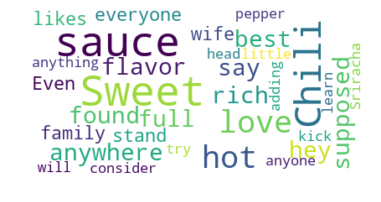

Amazon Review - 2
I first drank this tea at Naniboujou Lodge on the North Shore of Minnesota, and bought a small packet up there. I was hooked, so after I had drunk the first bit I bought I wanted to get more of this tea ASAP. Was glad to see it for sale in such a high quantity here. I used to be a coffee drinker, but I much prefer tea -- specifically, Ashbys Afternoon Tea -- now, and I just gave away a bag of coffee I'll never drink. I never quite got why British people are so into tea, but -- whether this is a typical British tea or not, I don't know -- I now see why they'd build their afternoons around a high-quality tea like this one. Sublime.
****************************************************************************************************


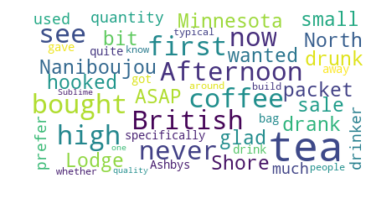

Amazon Review - 3
These chocolate covered espresso beans are wonderful!  The chocolate is very dark and rich and the "bean" inside is a very delightful blend of flavors with just enough caffine to really give it a zing.
****************************************************************************************************


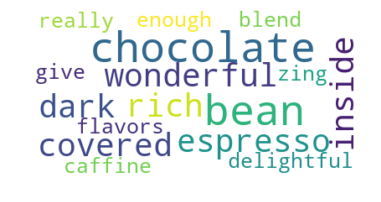

In [94]:
# For Cluster -5
counter = 1;
for i in range(len(cluster5)):
    if i == 3:
        break;
    else:
        print("Amazon Review -",counter)
        print(cluster5[i])
        print("*"*100)
        cluster_wordcloud(cluster5[i])
    counter +=1

## [5.3] DBSCAN Clustering

In [0]:
from sklearn.cluster import DBSCAN

### [5.3.1] Applying DBSCAN on AVG W2V,<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation
# We will define an helper function that will be used in implementating DBSCAN Algorithm

# We can see some of the labels in the DBSCAN model is -1 which represent the noisy data so we will compute the cluster for 
# the noisy data too and represent the reviews in them in a wordcloud.

def DBSCAN_implementation_different_eps(n_eps , min_pts , vector):
    
    for eps_val in n_eps:
        model = DBSCAN(eps=eps_val, min_samples=min_pts).fit(vector)
        print("*" * 30, "DBSCAN with EPS = ", eps_val, "  ", "*" * 30)
        
        clusters_list = list(set(model.labels_))
        
        #finding the length of the cluster:
        n_clusters = len(set(model.labels_))
        
        print("DBSCAN with EPS =%.3f and min_pts = %d the no. of Clusters = %d"%(eps_val,min_pts,n_clusters))
        
        
        for cluster in clusters_list:
            review_count = 1
            print("*" * 100)
            
            if cluster == -1:
                print("Noisy point label in cluster - ",cluster)
            else:
                print("Reviews of cluster = ",cluster+1)
                print("*" * 100)
                
            for i in range(model.labels_.shape[0]):
                if model.labels_[i] == cluster:
                    if review_count == 3:
                        break;
                    else:
                        print('Review - ',review_count)
                        print(reviews[i])
                        cluster_wordcloud(reviews[i])
                        review_count += 1
        
        print("*" * 100)
        print("\n")

In [0]:
#The below function will find the Kth distance to the points in the cluster:
def Kth_neighbour_distance(vect , n):
    distance_matrix = []
    for p in vect:
        p_vect_distance = np.sort(np.sum((vect - p)**2,axis=1),axis=None)
        
        distance_matrix.append(p_vect_distance[n])
    return np.sqrt(np.array(distance_matrix))

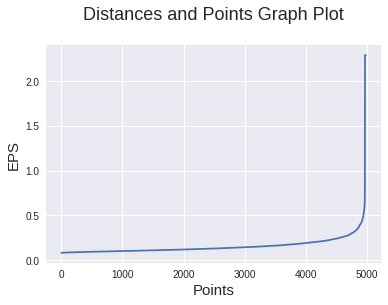

In [95]:
min_pts = 2*sent_vectors.shape[1]

# Computing the  distances for nth-nearest neighbours:
dist_matrix = Kth_neighbour_distance(sent_vectors,min_pts)

dist_sorted = np.sort(dist_matrix)

X_points = [x for x in range(sent_vectors.shape[0])]

# Plotting Distance(Eps or Kth distances) VS points:

plt.plot(X_points, dist_sorted)
plt.xlabel('Points',size=15)
plt.ylabel('EPS',size=15)
plt.title('Distances and Points Graph Plot\n',size=18)
plt.grid(True)
plt.show()

****************************** DBSCAN with EPS =  0.25    ******************************
DBSCAN with EPS =0.250 and min_pts = 400 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


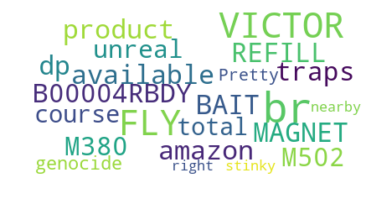

Review -  2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


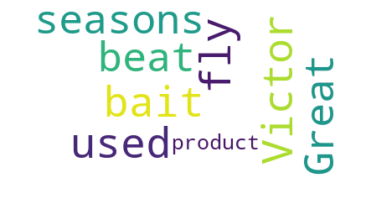

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...


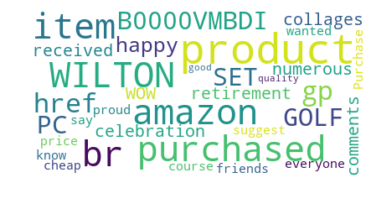

Review -  2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!


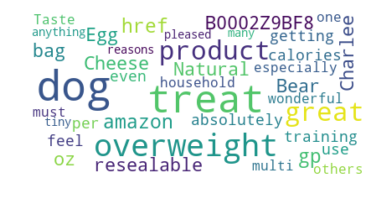

****************************************************************************************************


****************************** DBSCAN with EPS =  0.5    ******************************
DBSCAN with EPS =0.500 and min_pts = 400 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


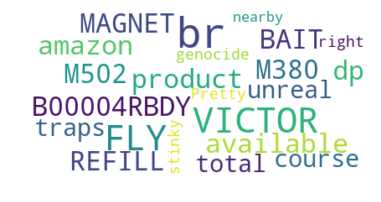

Review -  2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


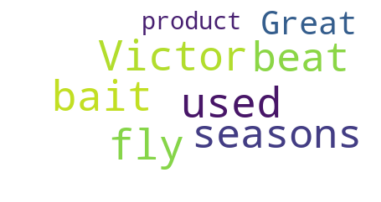

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...


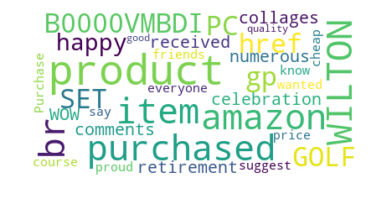

Review -  2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!


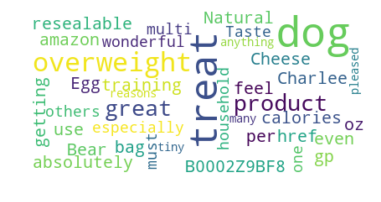

****************************************************************************************************


****************************** DBSCAN with EPS =  1.0    ******************************
DBSCAN with EPS =1.000 and min_pts = 400 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


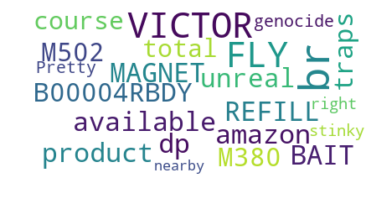

Review -  2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


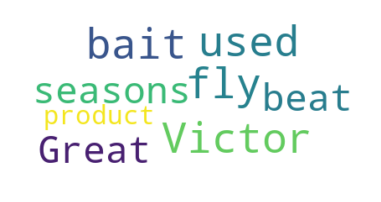

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...


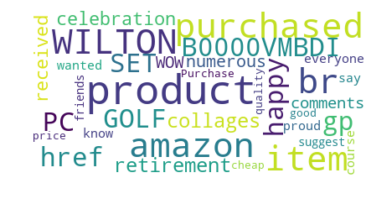

Review -  2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!


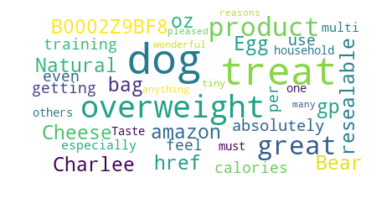

****************************************************************************************************




In [96]:
eps_list = [0.25,0.50,1.0]
DBSCAN_implementation_different_eps(eps_list,min_pts,sent_vectors)

### [5.3.2] Wordclouds of clusters obtained after applying DBSCAN on AVG W2V<font color='red'> SET 3</font>

In [0]:
# Please write all the code with proper documentation

### [5.3.3] Applying DBSCAN on TFIDF W2V,<font color='red'> SET 4</font>

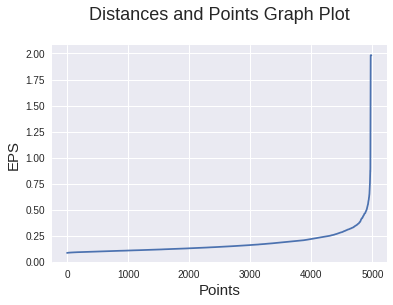

In [97]:
# Please write all the code with proper documentation
min_pts = 2*tfidf_sent_vectors[0].shape[0]

# Computing the  distances for nth-nearest neighbours:
dist_matrix = Kth_neighbour_distance(tfidf_sent_vectors,min_pts)

dist_sorted = np.sort(dist_matrix)

X_points = [x for x in range(len(tfidf_sent_vectors))]

# Plotting Distance(Eps or Kth distances) VS points:

plt.plot(X_points, dist_sorted)
plt.xlabel('Points',size=15)
plt.ylabel('EPS',size=15)
plt.title('Distances and Points Graph Plot\n',size=18)
plt.grid(True)
plt.show()

### [5.3.4] Wordclouds of clusters obtained after applying DBSCAN on TFIDF W2V<font color='red'> SET 4</font>

****************************** DBSCAN with EPS =  0.25    ******************************
DBSCAN with EPS =0.250 and min_pts = 400 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


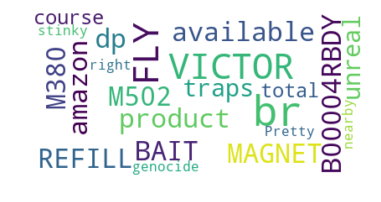

Review -  2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


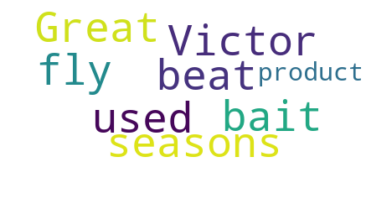

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...


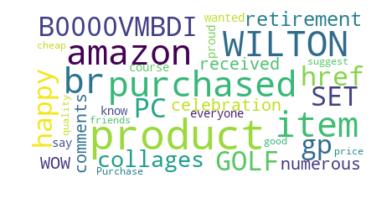

Review -  2
Good beans.  I can't find these in the grocery stores where I live, but ordered them through this retailer with no problems.


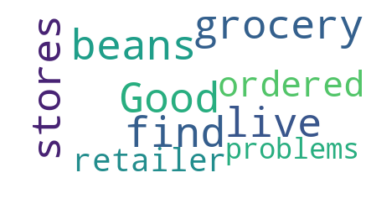

****************************************************************************************************


****************************** DBSCAN with EPS =  0.5    ******************************
DBSCAN with EPS =0.500 and min_pts = 400 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


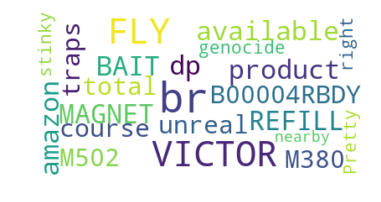

Review -  2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


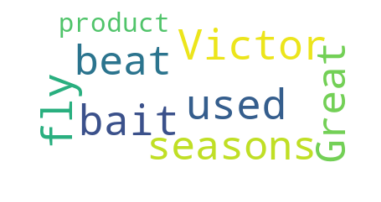

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...


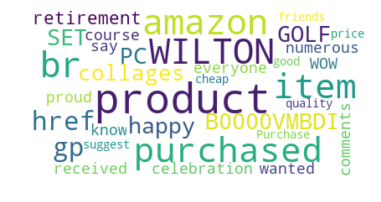

Review -  2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!


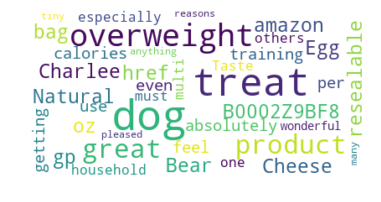

****************************************************************************************************


****************************** DBSCAN with EPS =  0.75    ******************************
DBSCAN with EPS =0.750 and min_pts = 400 the no. of Clusters = 2
****************************************************************************************************
Reviews of cluster =  1
****************************************************************************************************
Review -  1
Why is this $[...] when the same product is available for $[...] here?<br />http://www.amazon.com/VICTOR-FLY-MAGNET-BAIT-REFILL/dp/B00004RBDY<br /><br />The Victor M380 and M502 traps are unreal, of course -- total fly genocide. Pretty stinky, but only right nearby.


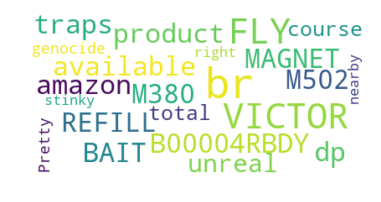

Review -  2
We have used the Victor fly bait for 3 seasons.  Can't beat it.  Great product!


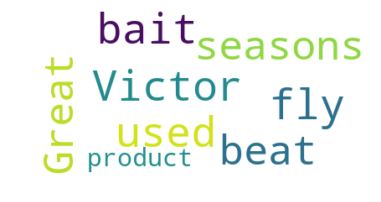

****************************************************************************************************
Noisy point label in cluster -  -1
Review -  1
<a href="http://www.amazon.com/gp/product/B0000VMBDI">WILTON 13 PC GOLF SET 1306-7274</a><br /><br />I am very happy with this product I purchased this item for my collages retirement celebration. I have received numerous comments! WOW everyone wanted to know where I purchased these Items; of course I was proud to say amazon.com..... I would suggest my friends to Purchase this product from Wilton as the price is very cheap and the quality is very good...


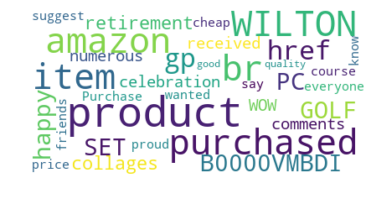

Review -  2
<a href="http://www.amazon.com/gp/product/B0002Z9BF8">All Natural Dog Treats by Charlee Bear - Cheese & Egg - 16 oz resealable bag</a> These are absolutely great treats for training and for use with overweight dogs. At only 4 calories per treat, even an overweight dog can feel like they are getting treats too, especially in a multi-dog household where one dog is overweight, others are not. Taste must be wonderful since there isn't anything my dogs won't do for these tiny treats, so I'm very pleased with them for many reasons! GREAT PRODUCTS!!!


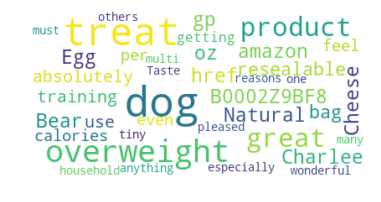

****************************************************************************************************




In [98]:
# Please write all the code with proper documentation
eps_list = [0.25,0.50,0.75]
DBSCAN_implementation_different_eps(eps_list,min_pts,tfidf_sent_vectors)

# [6] Conclusions

In [103]:
# Please compare all your models using Prettytable library. 
# Performance of Hierarchical clustering & DBSCAN

# Names of the models
names =['Hierarchical clustering for avgw2vec','Hierarchical clustering for Tf-idfW2Vec']

# Number of Clusters
n_clusters = ["2 & 5", "2 & 5"]
numbering = [1,2]
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Clusters",n_clusters)

# Printing the Table
print(ptable)



+-------+-----------------------------------------+----------+
| S.NO. |                  MODEL                  | Clusters |
+-------+-----------------------------------------+----------+
|   1   |   Hierarchical clustering for avgw2vec  |  2 & 5   |
|   2   | Hierarchical clustering for Tf-idfW2Vec |  2 & 5   |
+-------+-----------------------------------------+----------+


In [104]:
# Names of the models
names =['DBSCAN for avgw2vec','DBSCAN for Tf-idfW2Vec']

# Number of Clusters
n_clusters = [2,2]
minpts = [400,400]
eps = [0.50,0.75]
ptable = PrettyTable()

# Adding columns
ptable.add_column("S.NO.",numbering)
ptable.add_column("MODEL",names)
ptable.add_column("Clusters",n_clusters)
ptable.add_column("MinPts",minpts)
ptable.add_column("Eps",eps)
# Printing the Table
print(ptable)

+-------+------------------------+----------+--------+------+
| S.NO. |         MODEL          | Clusters | MinPts | Eps  |
+-------+------------------------+----------+--------+------+
|   1   |  DBSCAN for avgw2vec   |    2     |  400   | 0.5  |
|   2   | DBSCAN for Tf-idfW2Vec |    2     |  400   | 0.75 |
+-------+------------------------+----------+--------+------+
